# Classification of Handwritten Digits with SVD

In [62]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from scipy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from time import time

% matplotlib inline

In [63]:
# Reads the train and test sets into dataframes

x_train = pd.read_excel('data.xlsx', sheetname='azip', header = None, index_col = None).transpose()
y_train = pd.read_excel('data.xlsx', sheetname='dzip', header = None, index_col = None).transpose()
x_test = pd.read_excel('data.xlsx', sheetname='testzip', header = None, index_col = None).transpose()
y_test = pd.read_excel('data.xlsx', sheetname='dtest', header = None, index_col = None).transpose()

# Breaks the train matrix into different matrices based on class and casts them into numpy arrays
train_arrays = {}

for i in range(10):
    train_arrays[i] = x_train[y_train.loc[:,0] == i]    

for key in train_arrays.keys():
    train_arrays[key] = train_arrays[key].as_matrix().T


In [64]:
# Applys SVD to each of the aforementioned matrices and stores them into a dictionary

svd_train = {}

for i in range(10):
    svd_train[i] = svd(train_arrays[i])

# Casts test data into numpy arrays

test_matrix = x_test.as_matrix()
y_test = y_test.as_matrix()
    
    
# Defines the simple truncated SVD for the first question with a universal k for all classes

def truncate_u(svd_train, k):
    truncated_u = {}
    for key in svd_train:
        truncated_u[key] = svd_train[key][0][:,:k]
    return truncated_u

# Defines the truncated SVD for the third question with different k for each class 
# based on precision and recall of the first question
    
def truncate_u_diff_k(svd_train):
    truncated_u = {}
    for key in svd_train: 
        if key == 0 or key == 1:
            truncated_u[key] = svd_train[key][0][:,:10]
        elif key == 3:
            truncated_u[key] = svd_train[key][0][:,:22]
        elif key == 5:
            truncated_u[key] = svd_train[key][0][:,:28]
        else:
            truncated_u[key] = svd_train[key][0][:,:16]
    return truncated_u

In [65]:
# Defines the classifier letting us choose different k and a choice for use_diff_k for each class which 
# calls the truncated_u_diff_k from above
# Returns y_pred tuples of (class, minimum norm) and accuracy (or accuracies if many k)

def classification(num_sv, svd_train, test_matrix, y_test, use_diff_k = 'no'):
    accuracies = []
    
    for k in num_sv:
        if use_diff_k == 'yes':
            truncated_u_train = truncate_u_diff_k(svd_train)           # Use different number of singular vectors for each class
        else:    
            truncated_u_train = truncate_u(svd_train, k)               # Use k singular vectors for all classes
        y_pred = []
        
        for z in test_matrix:                                          # Checks all test vectors
            res_norms = []
            for key in truncated_u_train:                              # Iterate over truncated matrix to calculate the residual
                shape = (truncated_u_train[key].shape)[0]              # norms
                I = np.eye(shape)
                U = truncated_u_train[key]
                res_norm = np.linalg.norm(np.dot(I - np.dot(U, U.T), z))
                res_norms.append((key,res_norm))
            y_pred.append(min(res_norms, key = lambda t:t[1]))         # Find the minimum residual norm and assign vector
                                                                       # to the respective class
        
        # Calculates error
        misclassified = [y_pred[i][0] for i in range(len(y_pred)) if y_test[i]!=y_pred[i][0]]
        
        # Calculates accuracy (or accuracies if the function is run for different number of singular vectors - num_sv)
        accuracy = 1-(len(misclassified)/len(y_pred))
        accuracies.append(accuracy)
    
    return ([y_pred[i][0] for i in range(len(y_pred))], accuracies)                                                       

# Task 1

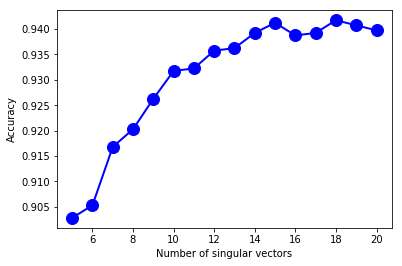

In [66]:
# Classification for different number of singular vectors between 5 and 20
k = np.array([i for i in range(5,21)])
y_pred, accuracies = classification(k, svd_train, test_matrix, y_test)

# Plot accuracies against number of singular vectors
accuracies = np.array(accuracies)
plt.plot(k, accuracies, color='b', marker='o',linewidth=2, markersize=12)
plt.xlabel('Number of singular vectors')
plt.ylabel('Accuracy')
plt.show()

Based on the above plot, we decide to use 15 singular vectors. Although 15 SVs do not provide us with the optimal accuracy, it's 3 SVs less than the optimal and for larger datasets this would have an impact on running time. Also, the two accuracies are pretty close.

In [67]:
# Prints classification report and confusion matrix for 15 singular vectors
results = np.array(classification([15], svd_train, test_matrix, y_test))
y_pred = results[0]
accuracy = results[1]
clf_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy: ", accuracy[0])                     
print(clf_report)                                     # Precision, recall, f1 score, support for each class
print(conf_matrix)                                    # Shows which classes are easily 
                                                      # confused for other classes during classification

Accuracy:  0.9412057797708022
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       359
          1       0.97      0.98      0.98       264
          2       0.95      0.90      0.93       198
          3       0.90      0.89      0.90       166
          4       0.93      0.93      0.93       200
          5       0.92      0.88      0.89       160
          6       0.98      0.95      0.96       170
          7       0.93      0.96      0.95       147
          8       0.95      0.92      0.94       166
          9       0.93      0.93      0.93       177

avg / total       0.94      0.94      0.94      2007

[[355   0   2   0   1   0   0   0   0   1]
 [  0 260   0   0   3   0   1   0   0   0]
 [  9   1 179   3   2   1   0   1   2   0]
 [  3   0   3 148   1   8   0   1   2   0]
 [  1   1   0   0 186   1   3   3   0   5]
 [  4   1   2   9   0 140   0   0   1   3]
 [  3   1   0   0   2   1 162   0   1   0]
 [  0   1   1   0   3   0   0 

# Task 2

It is obvious both from the confusion matrix and the precision and recall scores that not all digits are confused to the same extent. We can see that classes 5 and 3 are the most easily confused ones.

In the section below some instances of these classes are printed, so that we can assess the quality of the images. Indeed, they are quite different and in some cases they could be misinterpreted for other digits.

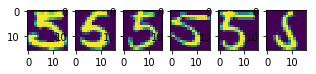

In [68]:
test_images = [train_arrays[5].T[i,:].reshape(16,16) for i in range(15)]
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(figsize=(5, 5), ncols=6)
ax1.imshow(test_images[0].reshape(16,16))
ax2.imshow(test_images[5].reshape(16,16))
ax3.imshow(test_images[7].reshape(16,16)) 
ax4.imshow(test_images[14].reshape(16,16)) 
ax5.imshow(test_images[9].reshape(16,16)) 
ax6.imshow(test_images[12].reshape(16,16)) 

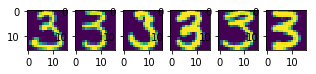

In [69]:
test_images = [train_arrays[3].T[i,:].reshape(16,16) for i in range(15)]
fig2, (ax7, ax8, ax9, ax10, ax11, ax12) = plt.subplots(figsize=(5, 5), ncols=6)
ax7.imshow(test_images[0].reshape(16,16))
ax8.imshow(test_images[5].reshape(16,16))
ax9.imshow(test_images[7].reshape(16,16)) 
ax10.imshow(test_images[14].reshape(16,16)) 
ax11.imshow(test_images[9].reshape(16,16)) 
ax12.imshow(test_images[12].reshape(16,16)) 

# Task 3

In [70]:
# Select different number of singular vectors based on classification report recall (descending)
start1 = time()
exprmnt_accuracy = classification([15], svd_train, test_matrix, y_test, use_diff_k = 'yes')[1]
end1 = time()
elapsed1 = end1 - start1

# Original function with 15 singular vectors for reference
start2 = time()
original_accuracy = classification([15], svd_train, test_matrix, y_test, use_diff_k = 'no')[1]
end2 = time()
elapsed2 = end2 - start2

print("Experimental accuracy: {}, Time in sec: {} ".format(exprmnt_accuracy[0], elapsed1))
print("Original accuracy: {}, Time in sec: {} ".format(original_accuracy[0], elapsed2))

Experimental accuracy: 0.9287493771798705, Time in sec: 8.02445912361145 
Original accuracy: 0.9412057797708022, Time in sec: 8.090462684631348 


We conclude that there is not really a reason to assign different k to different classes. The accuracy dropped despite the fact that we reduced the number of singular vectors for class 0, 1 by only 6, but increased the number of singular vectors for easily confused classes, namely 3 and 5 by 6 and 12 respectively. For the rest of the classes the number of singular vectors remained the same (15).

# Optional Task: Two - stage algorithm with SVD

In the section below we define a similar function to the one defined in the compulsory part of the project. The only difference is that we first check the classification capability for a single singular vector by checking the value of the minimum norm with respect to that of the second smaller norm and if it is larger than 80% of the latter, we decide to go with the original method, where 15 singular vectors are chosen.

In [71]:
def optional(svd_train, test_matrix, y_test): 
    accuracies = []
    
    truncated_u_train = truncate_u(svd_train, 1)
    truncated_u_train_bad = truncate_u(svd_train, 15)
    y_pred = []

    for z in test_matrix:
        res_norms = []
        for key in truncated_u_train:
            shape = (truncated_u_train[key].shape)[0]
            I = np.eye(shape)
            U = truncated_u_train[key]
            res_norm = np.linalg.norm(np.dot(I - np.dot(U, U.T), z))
            res_norms.append((key,res_norm))
        res_norms_sorted = sorted(res_norms, key = lambda t:t[1])
        
        if res_norms_sorted[0][0] >= 0.8 * res_norms_sorted[1][0]:
            for key in truncated_u_train_bad:    
                shape2 = (truncated_u_train_bad[key].shape)[0]
                I2 = np.eye(shape2)
                U2 = truncated_u_train_bad[key]
                res_norm = np.linalg.norm(np.dot(I2 - np.dot(U2, U2.T), z))
                res_norms.append((key,res_norm))
            y_pred.append(min(res_norms, key = lambda t: t[1]))
            
        else:
            y_pred.append(res_norms_sorted[0])

    misclassified = [y_pred[i][0] for i in range(len(y_pred)) if y_test[i]!=y_pred[i][0]]

    accuracy = 1-(len(misclassified)/len(y_pred))
    accuracies.append(accuracy)
    
    return ([y_pred[i][0] for i in range(len(y_pred))], accuracies)

start3 = time()
clf_results = optional(svd_train, test_matrix, y_test)
end3 = time()

y_pred_optional = clf_results[0]
accuracies_optional = clf_results[1]
clf_report_optional = classification_report(y_test, y_pred_optional)
conf_matrix_optional = confusion_matrix(y_test, y_pred_optional)

print("Time: ", end3-start3)
print("Accuracy: ", accuracies_optional[0])
print(clf_report_optional)
print(conf_matrix_optional)

Time:  10.96062684059143
Accuracy:  0.8794220229197808
             precision    recall  f1-score   support

          0       0.87      0.96      0.91       359
          1       0.88      0.99      0.93       264
          2       0.91      0.83      0.87       198
          3       0.79      0.88      0.83       166
          4       0.80      0.87      0.83       200
          5       0.90      0.76      0.82       160
          6       0.95      0.86      0.91       170
          7       0.88      0.93      0.90       147
          8       0.95      0.80      0.87       166
          9       0.95      0.78      0.85       177

avg / total       0.88      0.88      0.88      2007

[[345   0   3   1   4   1   4   0   0   1]
 [  0 261   0   0   3   0   0   0   0   0]
 [ 11   4 164   7   7   1   0   2   2   0]
 [  7   0   4 146   2   5   0   0   2   0]
 [  1  15   2   0 174   0   3   3   0   2]
 [ 13   2   1  18   1 121   0   0   1   3]
 [ 16   0   3   0   2   1 147   0   1   0]
 [  0

The total accuracy is considerably lower with this method, as expected and we can see from the precision, recall and f1 scores that in general we have more false positives and false negatives than before. The confusion matrix gives us the same idea about misclassifying certain classes, which were not as highly confused before.

However, the running time is also higher. This is due to the fact that we need to calculate the residual norms based on a single singular vector and check if the smaller one is too far from the second smaller one and if this is clause is not satisfied, then we need to recalculate the residual norms based on 15 singular vectors. This means that in many cases we need to calculate the norms twice, which adds to the running time.

All in all however, we can conclude that the SVD, in general, produces impressive classification results even for such a small number of selected singular vectors.